# INRIX Traffic Speed Data - Exploratory Data Analysis

This notebook performs exploratory data analysis on a large INRIX traffic speed CSV file. Due to the file's size, we'll first split it into smaller, more manageable chunks (< 100MB each) and then analyze the data to understand its characteristics and patterns.

## Workflow
1. Split the large CSV file into smaller chunks
2. Analyze data structure and statistics
3. Explore temporal patterns (daily, weekly, seasonal)
4. Analyze speed distributions
5. Identify correlations and relationships

## 1. Import Required Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import math
import time
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import calendar

# Set plotting styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Display all columns
pd.set_option('display.max_columns', None)

## 2. File Path and Settings

In [23]:
# Define file paths
inrix_file_name = "SR60-1year"
data_dir = Path(f'../database/inrix-traffic-speed/{inrix_file_name}')
large_file_path = data_dir / f"{inrix_file_name}.csv"

# Define the directory for saving chunks
chunks_dir = data_dir / "chunks"
os.makedirs(chunks_dir, exist_ok=True) # Create directory if it doesn't exist

# Define the target size for each chunk (in MB)
target_chunk_size_mb = 100  # ~100MB

## 3. Check File Size and Structure

In [24]:
# Check file size in MB
if large_file_path.exists():
    file_size_mb = os.path.getsize(large_file_path) / (1024 * 1024)
    print(f"File size: {file_size_mb:.2f} MB")
    
    # Estimate the number of chunks needed
    num_chunks = math.ceil(file_size_mb / target_chunk_size_mb)
    print(f"Estimated number of chunks needed: {num_chunks}")
else:
    print(f"File {large_file_path} does not exist!")

# Preview the first few rows to understand the structure
try:
    df_sample = pd.read_csv(large_file_path, nrows=5)
    print("\nSample of the dataset (first 5 rows):")
    display(df_sample)
    
    # Get column information
    print("\nColumns in the dataset:")
    for col in df_sample.columns:
        print(f"- {col} (type: {df_sample[col].dtype})")
        
except Exception as e:
    print(f"Error reading file: {e}")

File size: 3020.90 MB
Estimated number of chunks needed: 31

Sample of the dataset (first 5 rows):


,tmc_code,measurement_tstamp,speed,historical_average_speed,reference_speed,travel_time_seconds,confidence_score,cvalue,Inrix 2013,Inrix 2019
0,115+04387,2024-09-24 00:00:00,51.0,49.0,49.0,10.98,30.0,100.0,2,6
1,115+04387,2024-09-24 00:01:00,52.0,49.0,49.0,10.77,30.0,100.0,2,6
2,115+04387,2024-09-24 00:02:00,51.0,49.0,49.0,10.98,30.0,100.0,2,6
3,115+04387,2024-09-24 00:03:00,51.0,49.0,49.0,10.98,30.0,100.0,2,6
4,115+04387,2024-09-24 00:04:00,51.0,49.0,49.0,10.98,30.0,100.0,2,6



Columns in the dataset:
- tmc_code (type: object)
- measurement_tstamp (type: object)
- speed (type: float64)
- historical_average_speed (type: float64)
- reference_speed (type: float64)
- travel_time_seconds (type: float64)
- confidence_score (type: float64)
- cvalue (type: float64)
- Inrix 2013 (type: int64)
- Inrix 2019 (type: int64)


## 4. Split the File into Smaller Chunks

In [25]:
def split_csv_file(file_path, output_dir, target_chunk_size_mb=95, chunksize=10000):
    """
    Split a large CSV file into smaller chunks
    
    Parameters:
    -----------
    file_path : str or Path
        Path to the large CSV file
    output_dir : str or Path
        Directory to save the chunks
    target_chunk_size_mb : float
        Target size for each chunk in MB
    chunksize : int
        Number of rows to read at once
        
    Returns:
    --------
    list
        List of paths to the created chunk files
    """
    start_time = time.time()
    chunk_files = []
    
    # Convert paths to strings for pandas
    file_path_str = str(file_path)
    output_dir_str = str(output_dir)
    
    # Get the base filename without extension
    base_filename = os.path.splitext(os.path.basename(file_path_str))[0]
    
    # Read the CSV in chunks
    reader = pd.read_csv(file_path_str, chunksize=chunksize)
    
    # Initialize variables for tracking
    chunk_idx = 1
    current_chunk_size = 0
    current_chunk_rows = []
    
    # Get total rows (approximate)
    if os.path.exists(file_path_str):
        # Count lines quickly
        with open(file_path_str, 'r') as f:
            total_rows = sum(1 for _ in f) - 1  # Subtract header
        print(f"Processing file with {total_rows} rows")
    else:
        total_rows = 0
    
    # Process each chunk
    rows_processed = 0
    for i, chunk in enumerate(reader):
        # Add the current chunk rows
        current_chunk_rows.append(chunk)
        
        # Track progress
        rows_processed += len(chunk)
        if (i + 1) % 10 == 0:  # Print status every 10 chunks
            percent_done = (rows_processed / total_rows) * 100 if total_rows > 0 else 0
            print(f"Processed {rows_processed} rows ({percent_done:.1f}%)")
        
        # Calculate the size of the current chunk in memory
        chunk_size_mb = sum(chunk.memory_usage(deep=True)) / (1024 * 1024)
        current_chunk_size += chunk_size_mb
        
        # Apply a correction factor to better match target file size
        # Memory size vs file size ratio is typically around 2.5-3x
        adjusted_size = current_chunk_size * 0.4  # Adjust this factor based on testing
        
        # If we've reached the target size or it's the last chunk
        if adjusted_size >= target_chunk_size_mb:
            # Combine all accumulated chunks
            combined_chunk = pd.concat(current_chunk_rows, ignore_index=True)
            
            # Save the combined chunk
            chunk_filename = f"{base_filename}_chunk_{chunk_idx:03d}.csv"
            chunk_path = os.path.join(output_dir_str, chunk_filename)
            combined_chunk.to_csv(chunk_path, index=False)
            
            # Add to list of chunk files
            chunk_files.append(chunk_path)
            
            # Log information
            print(f"Saved chunk {chunk_idx}: {len(combined_chunk)} rows, {current_chunk_size:.2f} MB in memory")
            
            # Check actual file size
            actual_file_size_mb = os.path.getsize(chunk_path) / (1024 * 1024)
            print(f"  -> Actual file size: {actual_file_size_mb:.2f} MB")
            
            # Reset for the next chunk
            chunk_idx += 1
            current_chunk_size = 0
            current_chunk_rows = []
    
    # Save any remaining rows
    if current_chunk_rows:
        combined_chunk = pd.concat(current_chunk_rows, ignore_index=True)
        chunk_filename = f"{base_filename}_chunk_{chunk_idx:03d}.csv"
        chunk_path = os.path.join(output_dir_str, chunk_filename)
        combined_chunk.to_csv(chunk_path, index=False)
        chunk_files.append(chunk_path)
        
        print(f"Saved final chunk {chunk_idx}: {len(combined_chunk)} rows, {current_chunk_size:.2f} MB in memory")
        
        # Check actual file size
        actual_file_size_mb = os.path.getsize(chunk_path) / (1024 * 1024)
        print(f"  -> Actual file size: {actual_file_size_mb:.2f} MB")
    
    elapsed_time = time.time() - start_time
    print(f"\nFile splitting completed in {elapsed_time:.2f} seconds")
    print(f"Created {len(chunk_files)} chunk files")
    
    return chunk_files

In [26]:
# Execute the file splitting if the large file exists
if large_file_path.exists():
    print(f"Starting to split file: {large_file_path}")
    
    chunk_files = split_csv_file(
        large_file_path, 
        chunks_dir, 
        target_chunk_size_mb=target_chunk_size_mb,
        chunksize=50000  # Adjust this based on your memory capacity
    )
    
    # Display information about the created chunks
    print("\nCreated chunk files:")
    for i, chunk_file in enumerate(chunk_files):
        file_size_mb = os.path.getsize(chunk_file) / (1024 * 1024)
        print(f"{i+1}. {os.path.basename(chunk_file)}: {file_size_mb:.2f} MB")
else:
    print(f"File {large_file_path} does not exist. Cannot split the file.")

Starting to split file: ../database/inrix-traffic-speed/SR60-1year/SR60-1year.csv
Processing file with 43521980 rows
Processed 500000 rows (1.1%)
Processed 1000000 rows (2.3%)
Saved chunk 1: 1400000 rows, 253.68 MB in memory
  -> Actual file size: 92.99 MB
Processed 1500000 rows (3.4%)
Processed 2000000 rows (4.6%)
Processed 2500000 rows (5.7%)
Saved chunk 2: 1400000 rows, 253.68 MB in memory
  -> Actual file size: 92.80 MB
Processed 3000000 rows (6.9%)
Processed 3500000 rows (8.0%)
Processed 4000000 rows (9.2%)
Saved chunk 3: 1400000 rows, 253.68 MB in memory
  -> Actual file size: 92.89 MB
Processed 4500000 rows (10.3%)
Processed 5000000 rows (11.5%)
Processed 5500000 rows (12.6%)
Saved chunk 4: 1400000 rows, 253.68 MB in memory
  -> Actual file size: 92.91 MB
Processed 6000000 rows (13.8%)
Processed 6500000 rows (14.9%)
Processed 7000000 rows (16.1%)
Saved chunk 5: 1400000 rows, 253.68 MB in memory
  -> Actual file size: 92.93 MB
Processed 7500000 rows (17.2%)
Processed 8000000 rows

## 5. Exploratory Data Analysis

Now that we've split the large CSV file into smaller, more manageable chunks, let's analyze the data to understand its characteristics. We'll work with one of the chunks for our initial analysis.

In [27]:
# Get the list of chunk files after splitting
chunk_files = sorted(glob.glob(str(chunks_dir / f"*_chunk_*.csv")))

# If no chunk files found (maybe we didn't run the splitting yet), list any CSV files
if not chunk_files:
    chunk_files = sorted(glob.glob(str(chunks_dir / "*.csv")))

# If we have at least one chunk file, load the first one for analysis
if chunk_files:
    print(f"Loading first chunk file: {os.path.basename(chunk_files[0])}")
    df = pd.read_csv(chunk_files[0])
    print(f"Loaded {len(df)} rows with {len(df.columns)} columns")
else:
    print("No chunk files found for analysis!")
    # Create a sample dataframe for demonstration if no files exist
    df = pd.DataFrame()

Loading first chunk file: SR60-1year_chunk_001.csv
Loaded 1400000 rows with 10 columns


### 5.1 Data Overview and Basic Statistics

In [28]:
# Check if we have data to analyze
if not df.empty:
    # Basic information about the dataframe
    print("Dataset shape:", df.shape)
    
    # Display the first few rows
    print("\nFirst 5 rows:")
    display(df.head())
    
    # Display column information
    print("\nColumn information:")
    display(df.info())
    
    # Summary statistics for numerical columns
    print("\nSummary statistics for numerical columns:")
    display(df.describe())
    
    # Check for missing values
    missing_values = df.isnull().sum()
    missing_pct = (missing_values / len(df)) * 100;
    
    # Display missing values if any
    if missing_values.sum() > 0:
        print("\nMissing values by column:")
        missing_df = pd.DataFrame({
            'Column': missing_values.index,
            'Missing Count': missing_values.values,
            'Missing %': missing_pct.values
        })
        display(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))
    else:
        print("\nNo missing values found!")
else:
    print("No data available for analysis.")

Dataset shape: (1400000, 10)

First 5 rows:


,tmc_code,measurement_tstamp,speed,historical_average_speed,reference_speed,travel_time_seconds,confidence_score,cvalue,Inrix 2013,Inrix 2019
0,115+04387,2024-09-24 00:00:00,51.0,49.0,49.0,10.98,30.0,100.0,2.0,6
1,115+04387,2024-09-24 00:01:00,52.0,49.0,49.0,10.77,30.0,100.0,2.0,6
2,115+04387,2024-09-24 00:02:00,51.0,49.0,49.0,10.98,30.0,100.0,2.0,6
3,115+04387,2024-09-24 00:03:00,51.0,49.0,49.0,10.98,30.0,100.0,2.0,6
4,115+04387,2024-09-24 00:04:00,51.0,49.0,49.0,10.98,30.0,100.0,2.0,6



Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 10 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   tmc_code                  1400000 non-null  object 
 1   measurement_tstamp        1400000 non-null  object 
 2   speed                     1400000 non-null  float64
 3   historical_average_speed  1400000 non-null  float64
 4   reference_speed           1400000 non-null  float64
 5   travel_time_seconds       1400000 non-null  float64
 6   confidence_score          1400000 non-null  float64
 7   cvalue                    1398487 non-null  float64
 8   Inrix 2013                1349612 non-null  float64
 9   Inrix 2019                1400000 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 106.8+ MB


None


Summary statistics for numerical columns:


,speed,historical_average_speed,reference_speed,travel_time_seconds,confidence_score,cvalue,Inrix 2013,Inrix 2019
count,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.400000e+06,1.398487e+06,1.349612e+06,1.400000e+06
mean,6.527595e+01,6.539213e+01,6.631494e+01,2.875193e+01,2.998811e+01,9.978196e+01,6.299151e+01,4.124974e+01
std,1.060887e+01,1.153344e+01,1.026135e+01,2.190174e+01,4.609789e-01,1.566013e+00,4.719194e+01,2.778504e+01
min,4.000000e+00,1.100000e+01,2.500000e+01,1.630000e+00,1.000000e+01,3.100000e+01,0.000000e+00,1.000000e+00
25%,6.600000e+01,6.700000e+01,6.900000e+01,1.443000e+01,3.000000e+01,1.000000e+02,1.500000e+01,1.500000e+01
50%,6.900000e+01,7.000000e+01,7.000000e+01,2.730000e+01,3.000000e+01,1.000000e+02,6.000000e+01,4.000000e+01
75%,7.100000e+01,7.100000e+01,7.100000e+01,3.673000e+01,3.000000e+01,1.000000e+02,1.000000e+02,6.100000e+01
max,7.800000e+01,7.700000e+01,7.300000e+01,5.953000e+02,3.000000e+01,1.000000e+02,2.340000e+02,1.550000e+02



Missing values by column:


,Column,Missing Count,Missing %
8,Inrix 2013,50388,3.599143
7,cvalue,1513,0.108071


### 5.2 Data Type Handling and Preprocessing

Let's handle data types and preprocessing. If the dataset contains timestamp columns, we'll convert them to the appropriate format.

### 5.3 Speed Distribution Analysis

Let's analyze the distribution of traffic speeds, which is likely a key variable in the dataset.

Potential speed columns found: ['speed', 'historical_average_speed', 'reference_speed']


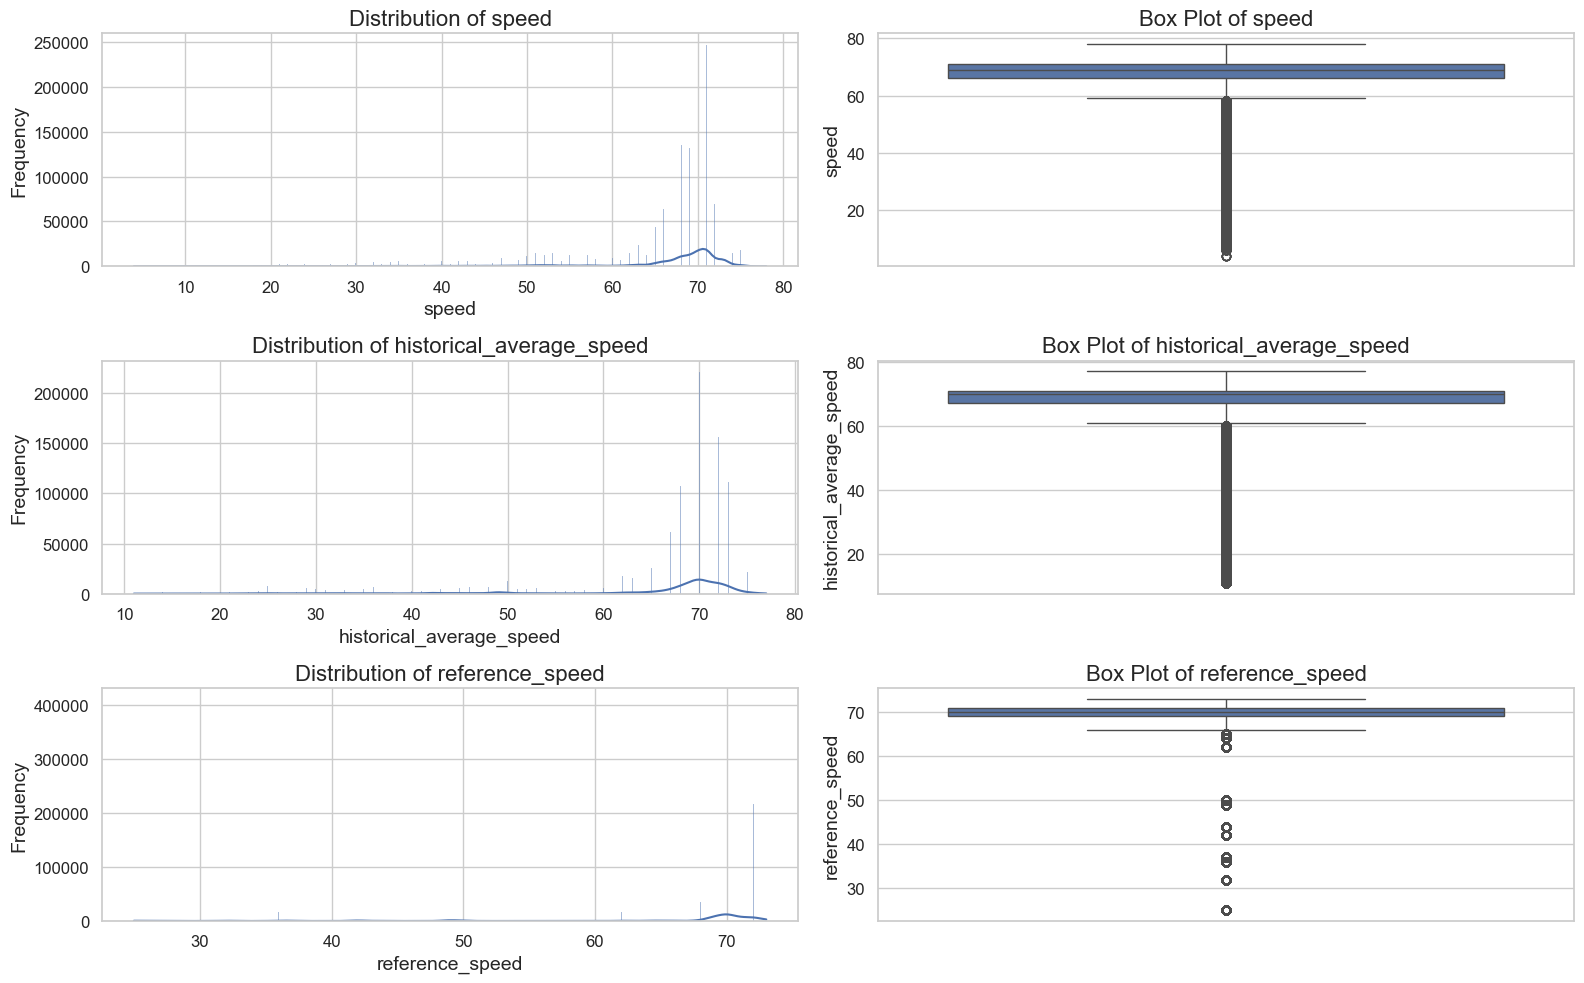


Statistics for speed:
Mean: 65.28
Median: 69.00
Min: 4.00
Max: 78.00
Standard Deviation: 10.61
5th percentile: 40.00
95th percentile: 73.00

Statistics for historical_average_speed:
Mean: 65.39
Median: 70.00
Min: 11.00
Max: 77.00
Standard Deviation: 11.53
5th percentile: 36.00
95th percentile: 74.00

Statistics for reference_speed:
Mean: 66.31
Median: 70.00
Min: 25.00
Max: 73.00
Standard Deviation: 10.26
5th percentile: 42.00
95th percentile: 72.00


In [29]:
if not df.empty:
    # Find speed-related columns
    speed_columns = ["speed", "historical_average_speed", "reference_speed"]
    
    print(f"Potential speed columns found: {speed_columns}")
    
    # If we found speed columns, analyze them
    if speed_columns:
        # Create histograms for each speed column
        plt.figure(figsize=(16, 10))
        
        for i, col in enumerate(speed_columns):
            plt.subplot(len(speed_columns), 2, 2*i+1)
            
            # Ensure the column has numerical data
            if pd.api.types.is_numeric_dtype(df[col]):
                # Histogram
                sns.histplot(df[col].dropna(), kde=True)
                plt.title(f"Distribution of {col}")
                plt.xlabel(col)
                plt.ylabel("Frequency")
                
                # Box plot
                plt.subplot(len(speed_columns), 2, 2*i+2)
                sns.boxplot(y=df[col].dropna())
                plt.title(f"Box Plot of {col}")
                plt.ylabel(col)
            else:
                plt.text(0.5, 0.5, f"{col} is not numeric", 
                         ha='center', va='center', transform=plt.gca().transAxes)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate basic statistics for speed columns
        for col in speed_columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                print(f"\nStatistics for {col}:")
                stats = df[col].describe()
                print(f"Mean: {stats['mean']:.2f}")
                print(f"Median: {df[col].median():.2f}")
                print(f"Min: {stats['min']:.2f}")
                print(f"Max: {stats['max']:.2f}")
                print(f"Standard Deviation: {stats['std']:.2f}")
                
                # Calculate percentiles
                print(f"5th percentile: {df[col].quantile(0.05):.2f}")
                print(f"95th percentile: {df[col].quantile(0.95):.2f}")
    else:
        print("No speed-related columns found in the dataset.")
else:
    print("No data available for speed distribution analysis.")

### 5.4 Temporal Analysis

If our dataset contains timestamp information, let's analyze how traffic patterns change over time.

In [30]:
df["measurement_tstamp"] = pd.to_datetime(df["measurement_tstamp"])

Found datetime columns: ['measurement_tstamp']
Using measurement_tstamp for temporal analysis
Using speed for speed metrics


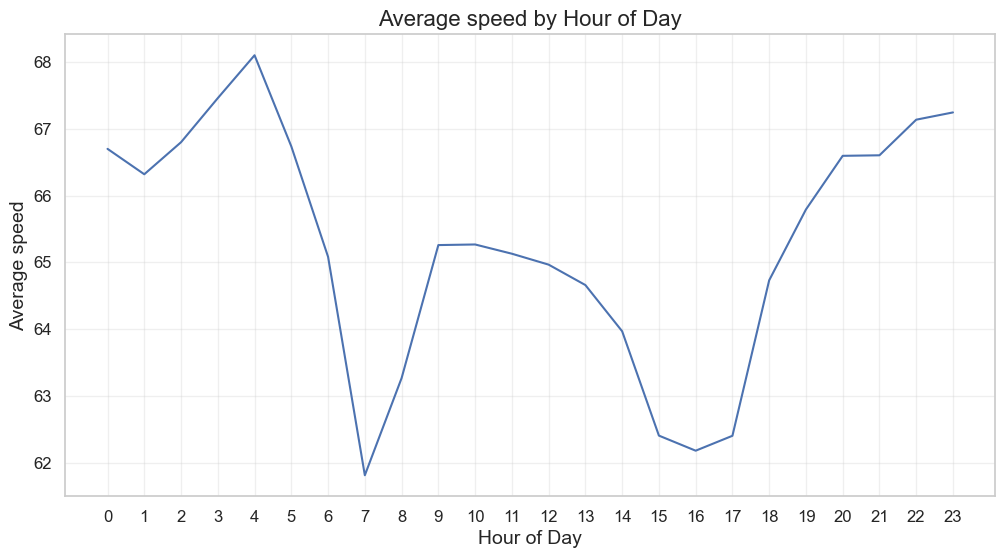

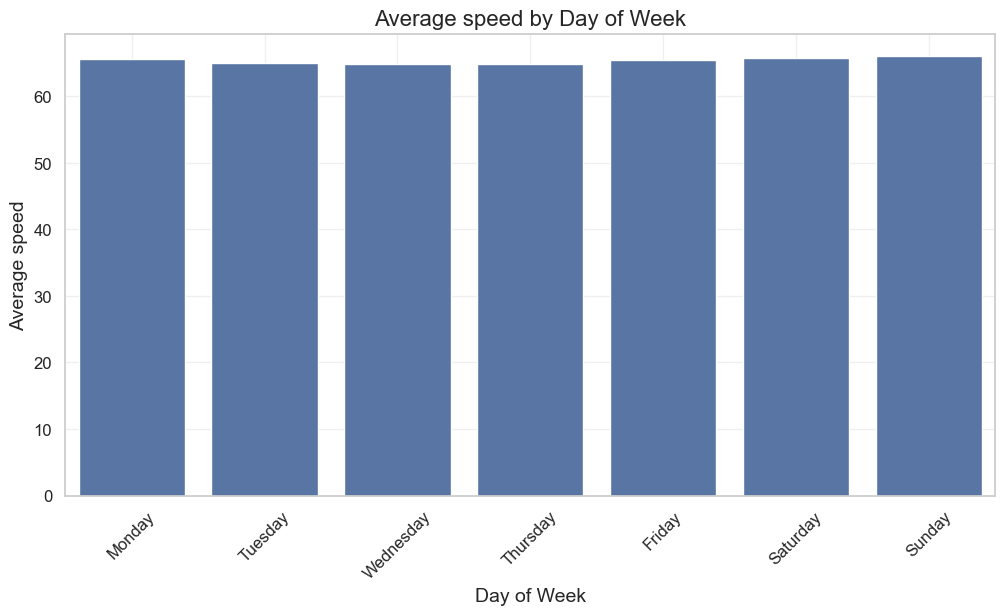

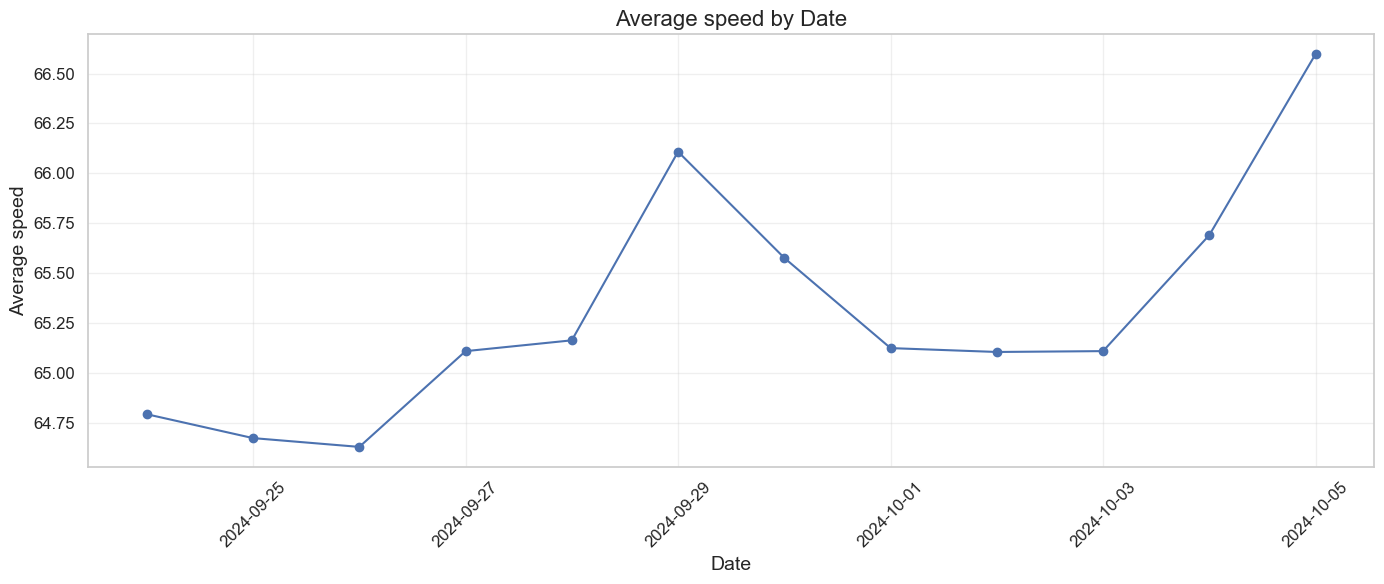

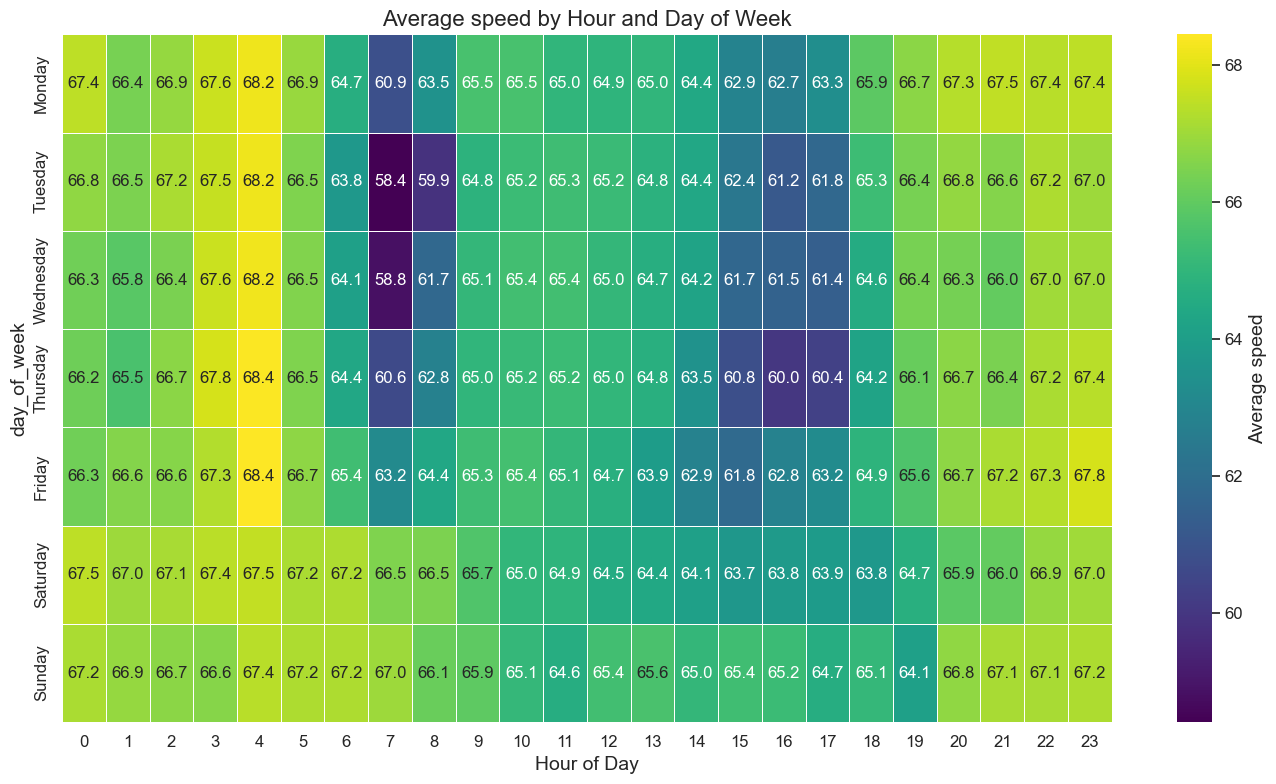

In [31]:
if not df.empty:
    # Check if we have datetime columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    
    if datetime_cols:
        print(f"Found datetime columns: {datetime_cols}")
        
        # Use the first datetime column for analysis
        time_col = datetime_cols[0]
        print(f"Using {time_col} for temporal analysis")
        
        # Extract time components
        df['hour'] = df[time_col].dt.hour
        df['day_of_week'] = df[time_col].dt.day_name()
        df['date'] = df[time_col].dt.date
        
        # Find a likely speed column for analysis
        speed_cols = ["speed"]
        
        if speed_cols:
            speed_col = speed_cols[0]  # Use the first identified speed column
            print(f"Using {speed_col} for speed metrics")
            
            # Ensure the column is numeric
            if pd.api.types.is_numeric_dtype(df[speed_col]):
                # 1. Average speed by hour of day
                plt.figure(figsize=(12, 6))
                hourly_speed = df.groupby('hour')[speed_col].mean()
                sns.lineplot(x=hourly_speed.index, y=hourly_speed.values)
                plt.title(f"Average {speed_col} by Hour of Day")
                plt.xlabel("Hour of Day")
                plt.ylabel(f"Average {speed_col}")
                plt.xticks(range(0, 24))
                plt.grid(True, alpha=0.3)
                plt.show()
                
                # 2. Average speed by day of week
                plt.figure(figsize=(12, 6))
                # Ensure proper day order
                day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                daily_speed = df.groupby('day_of_week')[speed_col].mean().reindex(day_order)
                sns.barplot(x=daily_speed.index, y=daily_speed.values)
                plt.title(f"Average {speed_col} by Day of Week")
                plt.xlabel("Day of Week")
                plt.ylabel(f"Average {speed_col}")
                plt.xticks(rotation=45)
                plt.grid(True, alpha=0.3)
                plt.show()
                
                # 3. Speed by date (if multiple dates available)
                if df['date'].nunique() > 1:
                    plt.figure(figsize=(14, 6))
                    date_speed = df.groupby('date')[speed_col].mean()
                    plt.plot(date_speed.index, date_speed.values, marker='o')
                    plt.title(f"Average {speed_col} by Date")
                    plt.xlabel("Date")
                    plt.ylabel(f"Average {speed_col}")
                    plt.grid(True, alpha=0.3)
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()
                
                # 4. Heatmap of hour vs day of week
                if df['date'].nunique() > 1:
                    plt.figure(figsize=(14, 8))
                    # Create pivot table
                    hour_day_pivot = df.pivot_table(
                        index='day_of_week', 
                        columns='hour',
                        values=speed_col,
                        aggfunc='mean'
                    ).reindex(day_order)  # Ensure proper day order
                    
                    # Create heatmap
                    sns.heatmap(
                        hour_day_pivot,
                        cmap='viridis',
                        annot=True,
                        fmt=".1f",
                        linewidths=.5,
                        cbar_kws={'label': f'Average {speed_col}'}
                    )
                    plt.title(f"Average {speed_col} by Hour and Day of Week")
                    plt.xlabel("Hour of Day")
                    plt.tight_layout()
                    plt.show()
            else:
                print(f"Column {speed_col} is not numeric. Cannot perform speed analysis.")
        else:
            print("No speed-related columns found for temporal analysis.")
    else:
        print("No datetime columns found for temporal analysis. Consider converting time-related columns to datetime format.")
else:
    print("No data available for temporal analysis.")

### 5.5 Seasonal Trend

Read all sliced csv files and aggregate data into 1hr intervals and save to a new dataframe df_1y. Only preserve columns tmc_code, time (by hour) and speed. Plot 
1. Trend line: plot daily average speed for the whole year → look for seasonal variation
2. Boxplots: speed distribution by month to see seasonal trends.
3. Heatmap: day-of-week × hour-of-day grid of mean speeds for each month (12 months)



In [32]:
chunks_dir

PosixPath('../database/inrix-traffic-speed/SR60-1year/chunks')

In [33]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from datetime import datetime, timedelta
# import calendar
# import glob
# import os

# Get all chunk files
all_chunk_files = sorted(glob.glob(str(chunks_dir / "*.csv")))
print(f"Found {len(all_chunk_files)} chunk files")

# Create a function to read and process each chunk file
def process_chunk_file(file_path):
    # Read the chunk file
    chunk_df = pd.read_csv(file_path)
    
    # Convert timestamp to datetime
    chunk_df['measurement_tstamp'] = pd.to_datetime(chunk_df['measurement_tstamp'])
    
    # Extract necessary columns (tmc_code, time, speed)
    chunk_df = chunk_df[['tmc_code', 'measurement_tstamp', 'speed']]
    
    # Round timestamp to the nearest hour for aggregation
    chunk_df['hour'] = chunk_df['measurement_tstamp'].dt.floor('h')
    
    # Aggregate data by tmc_code and hour
    agg_df = chunk_df.groupby(['tmc_code', 'hour']).agg(
        speed_mean=('speed', 'mean'),
        speed_median=('speed', 'median'),
        speed_min=('speed', 'min'),
        speed_max=('speed', 'max'),
        count=('speed', 'count')
    ).reset_index()
    
    return agg_df

# Process all chunk files and combine into a single dataframe
print("Processing chunk files and aggregating data...")
df_chunks = []

# Use simple progress tracking instead of tqdm
total_files = len(all_chunk_files)
for i, file_path in enumerate(all_chunk_files):
    if (i + 1) % 5 == 0 or i == 0 or i == total_files - 1:  # Report progress every 5 files
        print(f"Processing file {i+1}/{total_files} ({(i+1)/total_files*100:.1f}%)")
    df_chunks.append(process_chunk_file(file_path))

# Combine all processed chunks
df_1y = pd.concat(df_chunks, ignore_index=True)

# If there are duplicate entries for tmc_code and hour, aggregate again
df_1y = df_1y.groupby(['tmc_code', 'hour']).agg(
    speed_mean=('speed_mean', 'mean'),
    speed_median=('speed_median', 'mean'),
    speed_min=('speed_min', 'min'),
    speed_max=('speed_max', 'max'),
    count=('count', 'sum')
).reset_index()

# Extract additional time features for analysis
df_1y['date'] = df_1y['hour'].dt.date
df_1y['month'] = df_1y['hour'].dt.month
df_1y['month_name'] = df_1y['hour'].dt.month_name()
df_1y['day'] = df_1y['hour'].dt.day
df_1y['day_of_week'] = df_1y['hour'].dt.day_name()
df_1y['hour_of_day'] = df_1y['hour'].dt.hour

print(f"Created aggregated dataframe with {len(df_1y)} rows")
df_1y.head()

Found 32 chunk files
Processing chunk files and aggregating data...
Processing file 1/32 (3.1%)
Processing file 5/32 (15.6%)
Processing file 10/32 (31.2%)
Processing file 15/32 (46.9%)
Processing file 20/32 (62.5%)
Processing file 25/32 (78.1%)
Processing file 30/32 (93.8%)
Processing file 32/32 (100.0%)
Created aggregated dataframe with 725759 rows


,tmc_code,hour,speed_mean,speed_median,speed_min,speed_max,count,date,month,month_name,day,day_of_week,hour_of_day
0,115+04241,2024-09-24 00:00:00,68.083333,69.0,63.0,73.0,60,2024-09-24,9,September,24,Tuesday,0
1,115+04241,2024-09-24 01:00:00,66.066667,67.0,61.0,69.0,60,2024-09-24,9,September,24,Tuesday,1
2,115+04241,2024-09-24 02:00:00,67.000000,67.0,61.0,71.0,60,2024-09-24,9,September,24,Tuesday,2
3,115+04241,2024-09-24 03:00:00,68.800000,69.0,63.0,75.0,60,2024-09-24,9,September,24,Tuesday,3
4,115+04241,2024-09-24 04:00:00,69.933333,71.0,65.0,75.0,60,2024-09-24,9,September,24,Tuesday,4


Creating daily average speed trend line...


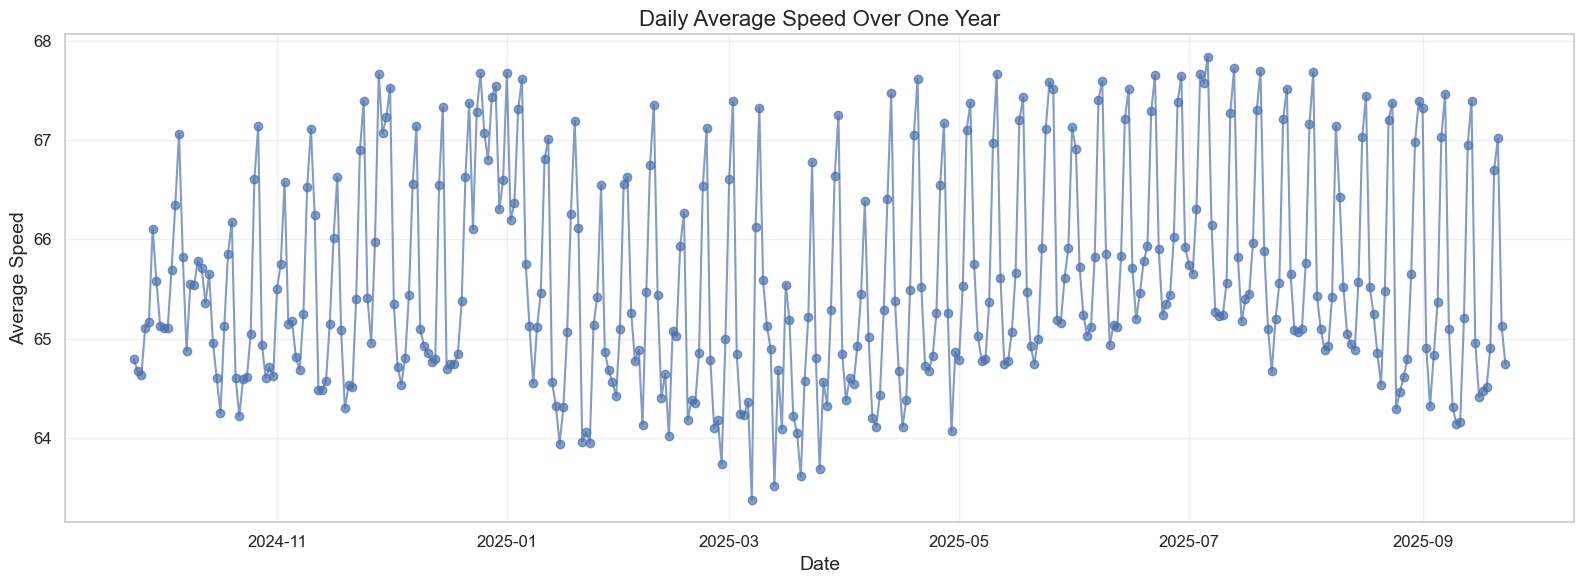


Creating speed distribution by month boxplots...


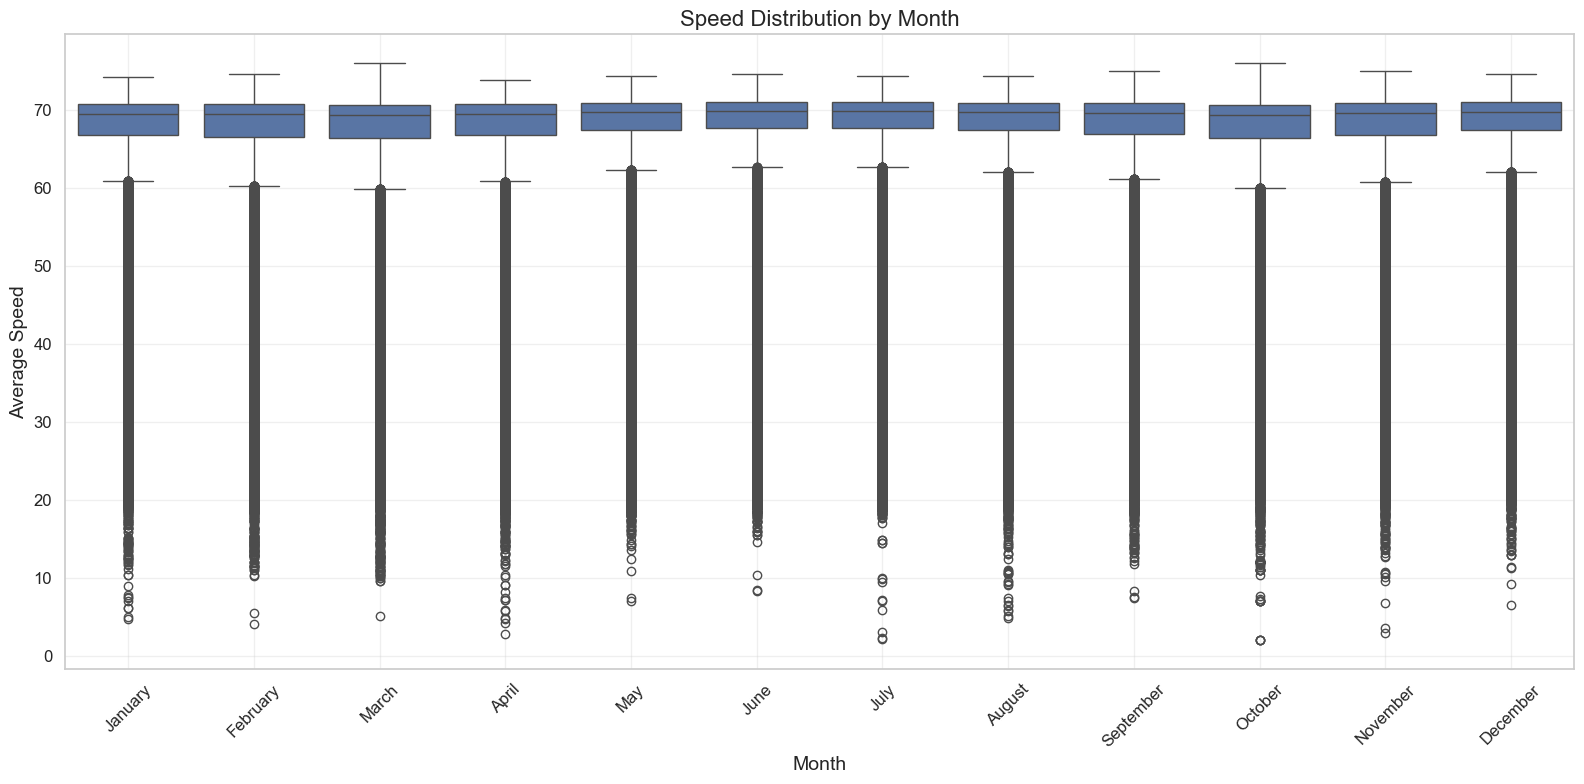


Monthly Speed Statistics:
                 mean     median        std
month_name                                 
January     65.465804  69.500000  10.120766
February    65.208956  69.433333  10.458630
March       65.064705  69.333333  10.578993
April       65.293737  69.450000  10.408429
May         65.899281  69.766667   9.994309
June        66.078100  69.816667   9.830123
July        66.066940  69.833333   9.804934
August      65.766376  69.733333  10.114653
September   65.392956  69.566667  10.345627
October     65.334882  69.300000  10.099119
November    65.683933  69.616667   9.946864
December    65.986976  69.800000   9.786498


In [34]:
# 1. Trend line: Plot daily average speed for the whole year
print("Creating daily average speed trend line...")

# Aggregate data by date
daily_avg = df_1y.groupby('date')['speed_mean'].mean().reset_index()
daily_avg['date'] = pd.to_datetime(daily_avg['date'])

plt.figure(figsize=(16, 6))
plt.plot(daily_avg['date'], daily_avg['speed_mean'], marker='o', linestyle='-', alpha=0.7)
plt.title('Daily Average Speed Over One Year')
plt.xlabel('Date')
plt.ylabel('Average Speed')
plt.grid(True, alpha=0.3)

# Add trendline using polynomial fit
# z = np.polyfit(range(len(daily_avg)), daily_avg['speed_mean'], 1)
# p = np.poly1d(z)
# plt.plot(daily_avg['date'], p(range(len(daily_avg))), "r--", lw=2)

plt.tight_layout()
plt.show()

# 2. Boxplots: Speed distribution by month
print("\nCreating speed distribution by month boxplots...")

# Set the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(16, 8))
sns.boxplot(x='month_name', y='speed_mean', data=df_1y, order=month_order)
plt.title('Speed Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Average Speed')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate monthly statistics
monthly_stats = df_1y.groupby('month_name')['speed_mean'].agg(['mean', 'median', 'std']).reindex(month_order)
print("\nMonthly Speed Statistics:")
print(monthly_stats)

In [35]:
# Import ipywidgets for interactive features
import ipywidgets as widgets 
from IPython.display import display

# Extract week information from the datetime
df_1y['week'] = df_1y['hour'].dt.isocalendar().week 
df_1y['year'] = df_1y['hour'].dt.isocalendar().year

# Create a year-week identifier (to handle week 1 potentially spanning two years)
df_1y['year_week'] = df_1y['year'].astype(str) + '-' + df_1y['week'].astype(str).str.zfill(2)

# Get unique year-weeks
unique_year_weeks = sorted(df_1y['year_week'].unique()) 
print(f"Found {len(unique_year_weeks)} weeks of data")

# Find global min and max for consistent colorbar
global_min = df_1y['speed_mean'].min() 
global_max = df_1y['speed_mean'].max()

# Create pivot tables for each week
weekly_pivots = {}
for year_week in unique_year_weeks:
    week_data = df_1y[df_1y['year_week'] == year_week]
    if len(week_data) > 0:
        pivot_data = week_data.pivot_table(
            index='day_of_week', columns='hour_of_day', values='speed_mean', aggfunc='mean'
        )
        # Reindex to ensure all days are in correct order
        pivot_data = pivot_data.reindex(day_order)
        weekly_pivots[year_week] = pivot_data

Found 53 weeks of data


In [36]:
# --- Plotting with Output widget ---

out = widgets.Output()

def plot_week_heatmap(week_idx):
    with out:
        out.clear_output(wait=True)
        year_week = unique_year_weeks[week_idx] 
        pivot_data = weekly_pivots.get(year_week)

        fig, ax = plt.subplots(figsize=(12, 8))

        if pivot_data is not None and not pivot_data.empty:
            mask = pivot_data.isna()
            sns.heatmap(
                pivot_data,
                cmap="viridis",
                annot=True,
                fmt=".1f",
                linewidths=.5,
                vmin=40,
                vmax=global_max,
                mask=mask,
                cbar_kws={"label": "Average Speed"},
                ax=ax
            )

            week_data = df_1y[df_1y['year_week'] == year_week]
            start_date = week_data['date'].min()
            end_date = week_data['date'].max()
            date_range = f"{start_date} to {end_date}" if start_date and end_date else year_week

            ax.set_title(f'Average Speed by Day and Hour: Week {year_week} ({date_range})', fontsize=16)
            ax.set_xlabel("Hour of Day")
            ax.set_ylabel("Day of Week")
        else:
            ax.text(0.5, 0.5, f"No data available for week {year_week}", 
                    ha="center", va="center", transform=ax.transAxes, fontsize=16)

        plt.tight_layout()
        display(fig)
        plt.close(fig)

# --- Widgets setup ---

if len(unique_year_weeks) > 0:
    week_label = widgets.Label(value=f"Week 1: {unique_year_weeks[0]}")

    week_slider = widgets.IntSlider(
        value=0, 
        min=0, 
        max=len(unique_year_weeks)-1, 
        step=1, 
        description='Week:', 
        continuous_update=False,
        layout=widgets.Layout(width='800px')
    )

    def on_slider_change(change):
        week_idx = change['new']
        week_label.value = f"Week {week_idx+1}: {unique_year_weeks[week_idx]}"
        plot_week_heatmap(week_idx)

    week_slider.observe(on_slider_change, names='value')

    display(widgets.VBox([week_label, week_slider, out]))

    # initial plot
    plot_week_heatmap(0)

else: 
    print("No weekly data available for visualization")


Analyzing seasonal patterns in the traffic data...
Seasonal Speed Statistics:
             mean     median        std
season                                 
Winter  65.565361  69.583333  10.119525
Spring  65.420718  69.516667  10.335227
Summer  65.969369  69.800000   9.919448
Fall    65.469590  69.483333  10.131211


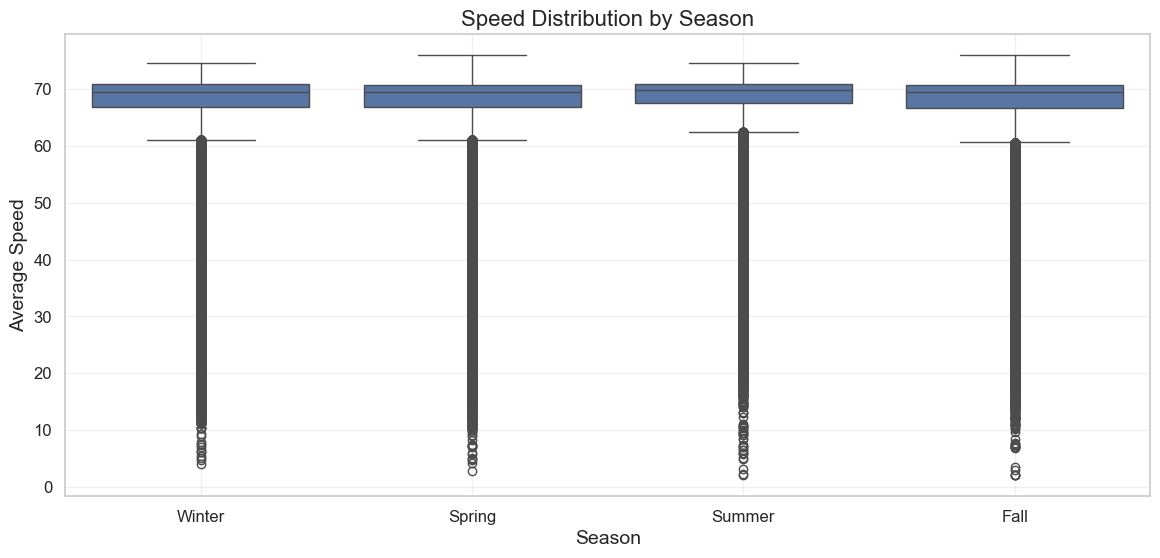

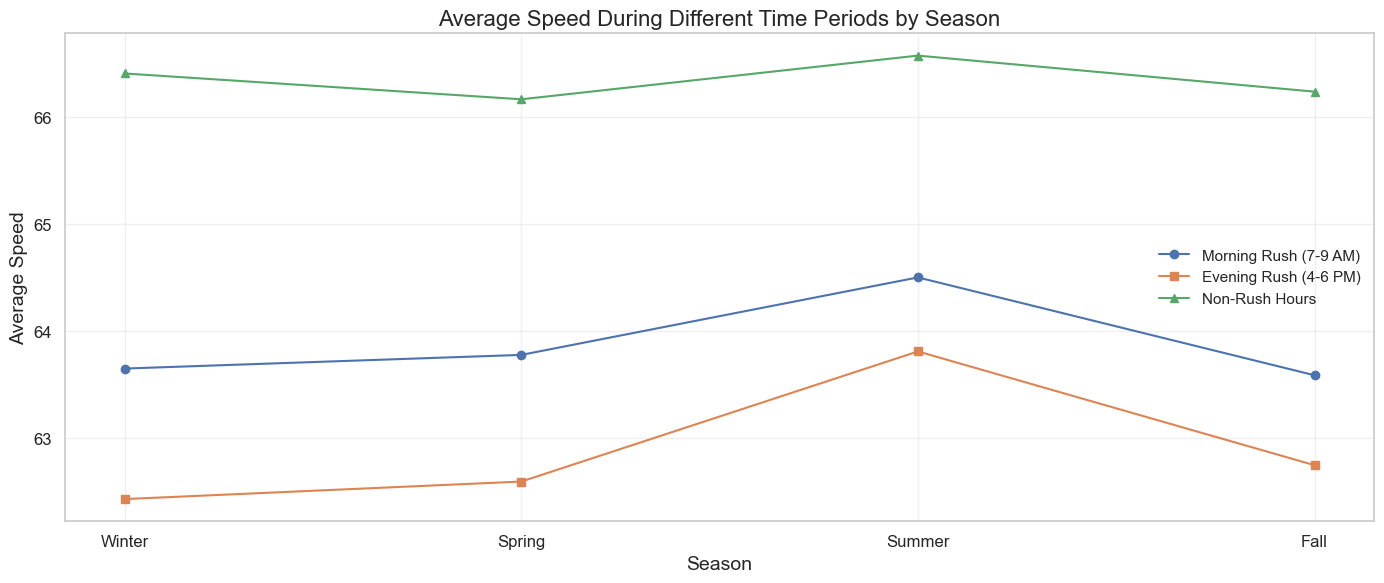

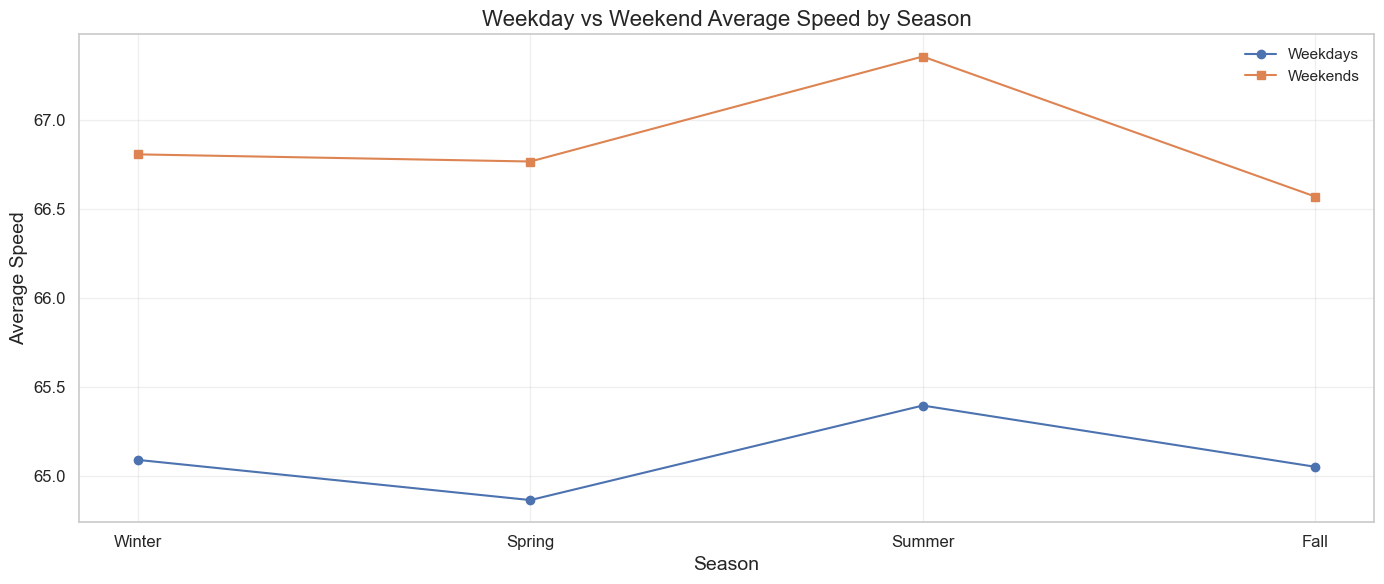


Seasonal Trend Analysis Complete!


In [37]:
# Summary of seasonal trends and patterns
print("\nAnalyzing seasonal patterns in the traffic data...")

# Calculate seasonal statistics (by meteorological seasons)
# Define seasons: Winter (Dec-Feb), Spring (Mar-May), Summer (Jun-Aug), Fall (Sep-Nov)
season_map = {
    1: 'Winter',  # January
    2: 'Winter',  # February
    3: 'Spring',  # March
    4: 'Spring',  # April
    5: 'Spring',  # May
    6: 'Summer',  # June
    7: 'Summer',  # July
    8: 'Summer',  # August
    9: 'Fall',    # September
    10: 'Fall',   # October
    11: 'Fall',   # November
    12: 'Winter'  # December
}

# Add season column
df_1y['season'] = df_1y['month'].map(season_map)

# Analyze by season
seasonal_stats = df_1y.groupby('season')['speed_mean'].agg(['mean', 'median', 'std']).reindex(['Winter', 'Spring', 'Summer', 'Fall'])
print("Seasonal Speed Statistics:")
print(seasonal_stats)

# Visualize seasonal variations
plt.figure(figsize=(14, 6))
sns.boxplot(x='season', y='speed_mean', data=df_1y, order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Speed Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Average Speed')
plt.grid(True, alpha=0.3)
plt.show()

# Analyze rush hour patterns by season
# Morning rush (7-9 AM)
df_1y['is_morning_rush'] = df_1y['hour_of_day'].between(7, 9)
# Evening rush (4-6 PM)
df_1y['is_evening_rush'] = df_1y['hour_of_day'].between(16, 18)

# Morning rush hour by season
morning_rush = df_1y[df_1y['is_morning_rush']].groupby('season')['speed_mean'].mean().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

# Evening rush hour by season
evening_rush = df_1y[df_1y['is_evening_rush']].groupby('season')['speed_mean'].mean().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

# Non-rush hour by season
non_rush = df_1y[~(df_1y['is_morning_rush'] | df_1y['is_evening_rush'])].groupby('season')['speed_mean'].mean().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

# Plot the comparison
plt.figure(figsize=(14, 6))
plt.plot(morning_rush.index, morning_rush.values, 'o-', label='Morning Rush (7-9 AM)')
plt.plot(evening_rush.index, evening_rush.values, 's-', label='Evening Rush (4-6 PM)')
plt.plot(non_rush.index, non_rush.values, '^-', label='Non-Rush Hours')
plt.title('Average Speed During Different Time Periods by Season')
plt.xlabel('Season')
plt.ylabel('Average Speed')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Weekday vs Weekend patterns by season
df_1y['is_weekend'] = df_1y['day_of_week'].isin(['Saturday', 'Sunday'])

# Weekday speeds by season
weekday = df_1y[~df_1y['is_weekend']].groupby('season')['speed_mean'].mean().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

# Weekend speeds by season
weekend = df_1y[df_1y['is_weekend']].groupby('season')['speed_mean'].mean().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

# Plot the comparison
plt.figure(figsize=(14, 6))
plt.plot(weekday.index, weekday.values, 'o-', label='Weekdays')
plt.plot(weekend.index, weekend.values, 's-', label='Weekends')
plt.title('Weekday vs Weekend Average Speed by Season')
plt.xlabel('Season')
plt.ylabel('Average Speed')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\nSeasonal Trend Analysis Complete!")

### 5.6 Spatial Analysis

Create an interactive Choropleth Maps of Average Speed aggregated every hour every road segment for a selected week.
Create an interactive slider to select week.
Display Choropleth Maps for the selected week and overlay the mean speed by segment on a map (openStreetMap), color-coded by speed (red = congested, orange = critical, green = free-flow).

In [38]:
# First, read the TMC_Identification.csv file to get location data for each TMC segment
print("Loading TMC location data...")
tmc_locations = pd.read_csv('../database/inrix-traffic-speed/SR60-1year/TMC_Identification.csv')
print(f"Loaded {len(tmc_locations)} TMC segments")
tmc_locations.head()

Loading TMC location data...
Loaded 166 TMC segments


,tmc,road,direction,intersection,state,county,zip,start_latitude,start_longitude,end_latitude,end_longitude,miles,road_order,timezone_name,type,country,active_start_date,active_end_date
0,115+04387,US-60,WESTBOUND,THOMAS RD/27TH AVE,AZ,MARICOPA,85009,33.47652,-112.11238,33.47815,-112.11424,0.155530,554.0,America/Phoenix,P1.11,USA,2025-04-29 14:00:00-04:00,NaN
1,115+04388,US-60,WESTBOUND,INDIAN SCHOOL RD,AZ,MARICOPA,85017,33.48440,-112.12171,33.49458,-112.13372,0.986850,555.0,America/Phoenix,P1.11,USA,2025-04-29 14:00:00-04:00,NaN
2,115N04388,US-60,EASTBOUND,INDIAN SCHOOL RD,AZ,MARICOPA,85019,33.49536,-112.13486,33.49496,-112.13442,0.037543,48.0,America/Phoenix,P1.11,USA,2025-04-29 14:00:00-04:00,NaN
3,115N04387,US-60,EASTBOUND,THOMAS RD/27TH AVE,AZ,MARICOPA,85017,33.48432,-112.12184,33.47821,-112.11452,0.607132,49.5,America/Phoenix,P1.11,USA,2025-04-29 14:00:00-04:00,NaN
4,115-10841,US-60,WESTBOUND,AZ-202 LOOP/EXIT 190,AZ,MARICOPA,85209,33.38684,-111.64061,33.38685,-111.64629,0.327688,517.0,America/Phoenix,P1.11,USA,2025-04-29 14:00:00-04:00,NaN


In [39]:
!pip install folium
!pip install geopandas

In [40]:
# Now we need to merge TMC location data with our aggregated speed data
# Create a function to join data for a specific week and prepare it for mapping

import folium
from folium.plugins import HeatMap
import branca.colormap as cm
import json
import geopandas as gpd

def prepare_tmc_data_for_map(df, tmc_locations, year_week):
    """
    Prepare TMC data for mapping by merging with location data.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataframe with speed data aggregated by TMC and time
    tmc_locations : pandas DataFrame
        DataFrame with TMC location data
    year_week : str
        Year-week identifier to filter data
        
    Returns:
    --------
    pandas DataFrame
        Data prepared for mapping with geographical coordinates
    """
    # Filter data for the selected week
    week_data = df[df['year_week'] == year_week].copy()
    
    # Aggregate by TMC code to get average speeds for the week
    tmc_weekly = week_data.groupby('tmc_code')['speed_mean'].mean().reset_index()
    
    # Merge with location data
    tmc_map_data = pd.merge(
        tmc_weekly,
        tmc_locations,
        left_on='tmc_code',
        right_on='tmc',
        how='inner'
    )
    
    print(f"Prepared map data with {len(tmc_map_data)} TMC segments")
    
    return tmc_map_data

# Create a function to generate a GeoJSON object for the map
def create_tmc_geojson(tmc_map_data):
    """
    Create a GeoJSON object from TMC data for mapping.
    
    Parameters:
    -----------
    tmc_map_data : pandas DataFrame
        Data with TMC, speed, and location information
        
    Returns:
    --------
    dict
        GeoJSON object for mapping
    """
    features = []
    
    for _, row in tmc_map_data.iterrows():
        # Create a LineString feature for each TMC segment
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "LineString",
                "coordinates": [
                    [row['start_longitude'], row['start_latitude']],
                    [row['end_longitude'], row['end_latitude']]
                ]
            },
            "properties": {
                "tmc": row['tmc'],
                "road": row['road'],
                "direction": row['direction'],
                "speed_mean": float(row['speed_mean']),
                "miles": float(row['miles'])
            }
        }
        features.append(feature)
    
    geojson = {
        "type": "FeatureCollection",
        "features": features
    }
    
    return geojson

# Define a function to determine color based on speed thresholds
def get_speed_color(speed):
    """
    Return color based on speed thresholds.
    
    Parameters:
    -----------
    speed : float
        Average speed
        
    Returns:
    --------
    str
        Hex color code
    """
    if speed < 35:  # Congested (adjust thresholds as needed)
        return '#FF0000'  # Red
    elif speed < 50:  # Critical
        return '#FFA500'  # Orange
    else:  # Free-flow
        return '#00FF00'  # Green

In [41]:
# Create a function to generate an interactive map for a specific week
def create_speed_map(df, tmc_locations, year_week):
    """
    Create an interactive map showing speed by TMC segment for a specific week.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with speed data
    tmc_locations : pandas DataFrame
        DataFrame with TMC location data
    year_week : str
        Year-week identifier to filter data
        
    Returns:
    --------
    folium.Map
        Interactive map object
    """
    # Prepare data for the map
    tmc_map_data = prepare_tmc_data_for_map(df, tmc_locations, year_week)
    
    if len(tmc_map_data) == 0:
        print(f"No data available for week {year_week}")
        return None
    
    # Find the center of the map
    center_lat = tmc_map_data['start_latitude'].mean()
    center_lon = tmc_map_data['start_longitude'].mean()
    
    # Create a map centered on the data
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=10,
        tiles='OpenStreetMap'
    )
    
    # Create GeoJSON data
    geojson_data = create_tmc_geojson(tmc_map_data)
    
    # Define a colormap for speed
    speed_min = max(20, tmc_map_data['speed_mean'].min())  # Set a minimum for better contrast
    speed_max = tmc_map_data['speed_mean'].max()
    
    # Add the GeoJSON to the map
    folium.GeoJson(
        geojson_data,
        name='TMC Segments',
        style_function=lambda feature: {
            'color': get_speed_color(feature['properties']['speed_mean']),
            'weight': 4,
            'opacity': 0.8
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['road', 'direction', 'speed_mean', 'miles'],
            aliases=['Road:', 'Direction:', 'Avg Speed (mph):', 'Length (miles):'],
            localize=True,
            sticky=False,
            labels=True,
            style="""
                background-color: #F0EFEF;
                border: 2px solid black;
                border-radius: 3px;
                box-shadow: 3px;
            """,
            max_width=300,
        ),
    ).add_to(m)
    
    # Add a color legend
    colormap = cm.LinearColormap(
        colors=['red', 'orange', 'green'],
        vmin=speed_min,
        vmax=speed_max,
        caption='Average Speed (mph)'
    )
    colormap.add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m

In [42]:
create_speed_map()

TypeError: create_speed_map() missing 3 required positional arguments: 'df', 'tmc_locations', and 'year_week'